In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qqpgfvah
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qqpgfvah
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=a0c5d611b05079123748af782ad31f2117f6dc25dfc201ad204d6b8dd27cd452
  Stored in directory: /tmp/pip-ephem-wheel-cache-cglz29u1/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
# from google.colab import files
# files.upload()

from google.colab import drive
drive.mount('/content/gdrive')

!unzip /content/gdrive/MyDrive/DL/100-bird-species.zip -d /content/100-bird-species

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/120.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/121.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/122.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/123.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/124.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/125.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/126.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/127.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/128.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/129.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/130.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC/131.jpg  
  inflating: /content/100-bird-species/train/WHITE TAILED TROPIC

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision

import clip
from PIL import Image
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [38]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [39]:
# Defining dataset path
data_dir = '/content/100-bird-species/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'

In [40]:
# Defining train transform and val transform along with data
train_transform = transforms.Compose([
  # transforms.Resize((224, 224)),
  transforms.Resize((64, 64)),
  # transforms.Resize((32, 32)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])

val_transform = transforms.Compose([
  # transforms.Resize((224, 224)),
  transforms.Resize((64, 64)),
  # transforms.Resize((32, 32)),
  transforms.ToTensor()
])

In [41]:
#Creating dataset
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(valid_dir,transform=val_transform)

In [42]:
batch_size = 64
# Creating dataloader
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size, shuffle=True)

In [43]:
# Defining num of classes
num_classes = len(train_dataset.classes)
print(num_classes)

525


In [44]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [45]:
device = get_default_device()
device

device(type='cuda')

In [46]:
# Pushing data to device
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

In [47]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, images, labels):
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, images, labels):
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [48]:
class BirdSpeciesCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.clip = clip_model.visual
        self.network = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))

    def forward(self, xb):
        xb = self.clip(xb)
        return self.network(xb)

In [49]:
model = BirdSpeciesCnnModel()
model

BirdSpeciesCnnModel(
  (clip): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=Tru

In [50]:
transform = transforms.ToPILImage()

In [52]:
from tqdm import tqdm
import copy

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = list()
    for images, labels in tqdm(val_loader):
      new_images = []
      for i, image in enumerate(images):
        image_input = preprocess(transform(image)).unsqueeze(0).to(device)
        image_input = image_input.squeeze()
        new_images.append(np.asarray(image_input.cpu()))
      new_images = np.asarray(new_images)
      new_images = torch.from_numpy(new_images)
      new_images = new_images.to(device)
      labels = labels.to(device)
      outputs.append(model.validation_step(new_images, labels))
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [53]:
def fit(epochs, lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for images, labels in tqdm(train_loader):
            new_images = []
            for i, image in enumerate(images):
              image_input = preprocess(transform(image)).unsqueeze(0).to(device)
              image_input = image_input.squeeze()
              new_images.append(np.asarray(image_input.cpu()))
            new_images = np.asarray(new_images)
            new_images = torch.from_numpy(new_images)

            new_images = new_images.to(device)
            loss = model.training_step(new_images, labels)
            train_losses.append(loss)
            loss.backward()
            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [54]:
model = BirdSpeciesCnnModel()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(valid_loader, device)
to_device(model, device)
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [55]:
if torch.cuda.is_available():
  model = model.type(torch.cuda.FloatTensor)
history = fit(epochs, max_lr, model, train_loader, valid_loader, weight_decay, grad_clip, opt_func)

100%|██████████| 42/42 [00:12<00:00,  3.47it/s]


Epoch [0], last_lr: 0.00003, train_loss: 5.0311, val_loss: 2.2759, val_acc: 0.6369


100%|██████████| 42/42 [00:12<00:00,  3.47it/s]


Epoch [1], last_lr: 0.00008, train_loss: 1.4153, val_loss: 0.8692, val_acc: 0.7909


100%|██████████| 42/42 [00:12<00:00,  3.50it/s]


Epoch [2], last_lr: 0.00010, train_loss: 0.9727, val_loss: 0.6295, val_acc: 0.8196


100%|██████████| 42/42 [00:12<00:00,  3.47it/s]


Epoch [3], last_lr: 0.00010, train_loss: 0.6782, val_loss: 0.5121, val_acc: 0.8709


100%|██████████| 42/42 [00:11<00:00,  3.52it/s]


Epoch [4], last_lr: 0.00008, train_loss: 0.4543, val_loss: 0.3575, val_acc: 0.9092


100%|██████████| 42/42 [00:12<00:00,  3.50it/s]


Epoch [5], last_lr: 0.00006, train_loss: 0.2805, val_loss: 0.3221, val_acc: 0.9137


100%|██████████| 42/42 [00:11<00:00,  3.55it/s]


Epoch [6], last_lr: 0.00004, train_loss: 0.1306, val_loss: 0.2550, val_acc: 0.9330


100%|██████████| 42/42 [00:11<00:00,  3.57it/s]


Epoch [7], last_lr: 0.00002, train_loss: 0.0384, val_loss: 0.1779, val_acc: 0.9539


100%|██████████| 42/42 [00:11<00:00,  3.53it/s]


Epoch [8], last_lr: 0.00000, train_loss: 0.0115, val_loss: 0.1563, val_acc: 0.9606


100%|██████████| 42/42 [00:12<00:00,  3.48it/s]


Epoch [9], last_lr: 0.00000, train_loss: 0.0051, val_loss: 0.1502, val_acc: 0.9621


In [56]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

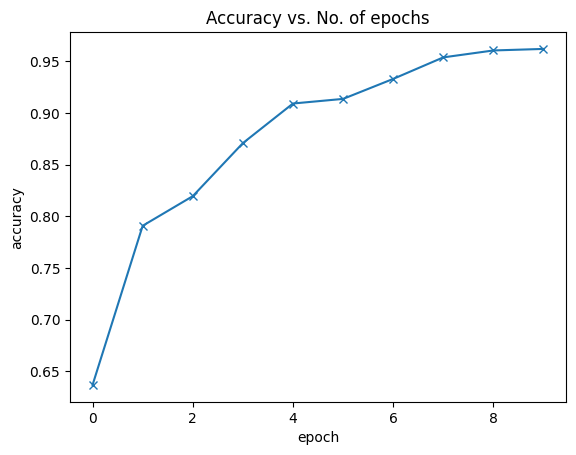

In [57]:
plot_accuracies(history)

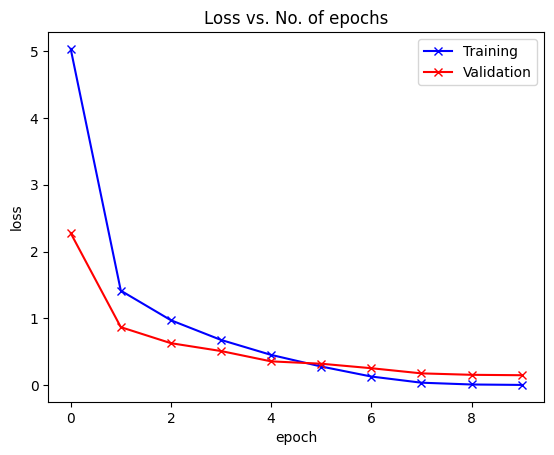

In [58]:
plot_losses(history)

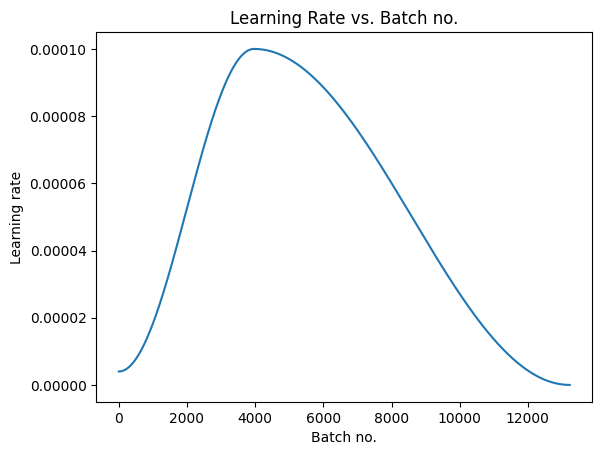

In [59]:
plot_lrs(history)

In [60]:
test_dataset = ImageFolder(data_dir+'/test', transform=val_transform)
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


{'val_loss': 0.08236730843782425, 'val_acc': 0.9788060784339905}

In [61]:
torch.save(model.state_dict(), 'Clip06.pth')